# Join and Pre-Process the New York City Datasets

Code responsible to Join and Pre-Process three New York City datasets:

- Housing: Info about Projects about each Bourough with the number of Poor and Rich house units
- Url: https://www.kaggle.com/new-york-city/housing-new-york-units

In [2]:
import re

import pandas as pd

In [16]:
df_housing = pd.read_table("Input/housing-new-york-units-by-building.csv", sep = ',')

In [17]:
dict_county = {'BRONX': 'BRONX', 'BROOKLYN': 'KINGS', 'MANHATTAN': 'NEW YORK',
               'QUEENS': 'QUEENS', 'STATEN ISLAND': 'RICHMOND'}

### Summarizing the number of Barthrooms 

In [18]:
br_features = list(filter(lambda x: 'BR Units' in x or
                          'BR+ Units' in x, df_housing.columns))
amount_br =  list(map(lambda x: re.sub(r'[^\d]*', '', x), br_features))
amount_br = list(filter(lambda x: x != '', amount_br))
amount_br = list(map(lambda x: int(x), amount_br))

df_housing.drop(['Unknown-BR Units'], axis = 1, inplace=True)
br_features.remove('Unknown-BR Units')

for index, row in df_housing.iterrows():
    values = list(map(lambda x: row[x], br_features))
    mean = sum([amount * value for amount, value in zip(amount_br, values)])/row['Total Units']
    df_housing.loc[index, 'Mean Bathrooms'] = mean

### Housing: Removing NoN Interesting Columns

In [19]:
pd.set_option('display.max_columns', 500)
removed_columns = ['Project ID', 'Project Start Date', 'Project Completion Date', 'Building ID',
                   'Number', 'Street', 'Postcode', 'Community Board', 'Council District',
                   'NTA - Neighborhood Tabulation Area', 'Project Name',
                   'Latitude (Internal)', 'Longitude (Internal)', 'Total Units',
                   'Counted Homeownership Units', 'Counted Rental Units', 'All Counted Units',
                   'Building Completion Date', 'BIN', 'BBL', 'Census Tract',
                   'Extended Affordability Only', 'Reporting Construction Type',
                   'Prevailing Wage Status'] + br_features

df_housing['Borough'] = list(map(lambda x: x.upper(), df_housing['Borough']))
df_housing['County'] = list(map(lambda x: dict_county[x], df_housing['Borough']))
df_housing = df_housing.drop(removed_columns, axis=1)
df_housing.head(5)

,Borough,Latitude,Longitude,Extremely Low Income Units,Very Low Income Units,Low Income Units,Moderate Income Units,Middle Income Units,Other Income Units,Studio Units,Mean Bathrooms,County
0,MANHATTAN,40.811202,-73.942995,0,16,24,0,38,1,16,1.35443,NEW YORK
1,MANHATTAN,40.833829,-73.941339,20,3,1,0,0,1,0,2.60000,NEW YORK
2,MANHATTAN,40.835160,-73.941663,6,11,3,0,0,0,0,2.00000,NEW YORK
3,MANHATTAN,40.835295,-73.941977,4,14,2,0,0,0,0,2.00000,NEW YORK
4,BROOKLYN,NaN,NaN,1,18,22,8,0,1,11,1.54000,KINGS


### Tasks:
- Verify the best way to complete the NaN values for each dataset
- Group the data by county
- Make a new dataset with the joined data

In [20]:
df_housing.dropna(axis = 0, how = 'any', subset  = ['Latitude', 'Longitude'], inplace = True)

In [21]:
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt

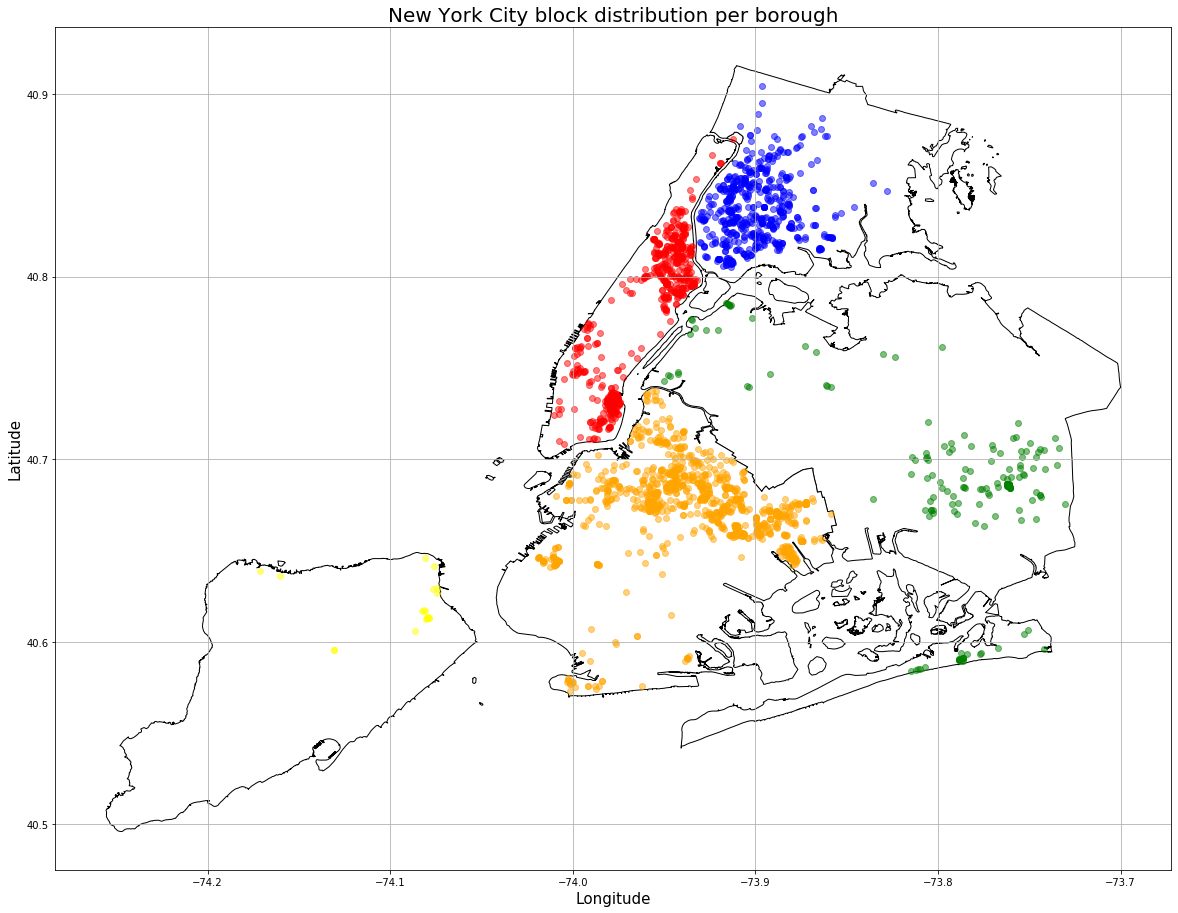

In [22]:
def block_evaluation(df):
    colors = ['Blue', 'Orange', 'Red', 'Green', 'Yellow']
    
    fig, ax = plt.subplots(figsize=(20, 20))
    world = geopandas.read_file(geopandas.datasets.get_path("nybb")) # open new york city map
    world.to_crs({"init": "epsg:4326"}).plot(ax=ax, color="white", edgecolor="black")
    boroughs = sorted(set(df['Borough']))

    for index, borough  in enumerate(boroughs):

        df_borough = df.loc[df['Borough'] == borough]
        x = df_borough['Longitude']
        y = df_borough['Latitude']

        geometry = [Point(xy) for xy in zip(x, y)]        
        geo_df = geopandas.GeoDataFrame(df_borough, geometry=geometry)

        plt.scatter(x, y, color=colors[index], alpha=0.5)
    
    plt.title("New York City block distribution per borough", fontsize = 20)
    plt.grid(True)
    plt.xlabel("Longitude", fontsize = 15)
    plt.ylabel("Latitude", fontsize = 15)

block_evaluation(df_housing)

In [25]:
df_housing.to_csv("Output/housing_data.csv", sep = ',', index = False)